In [119]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import io # Input/Output Module
import os # OS interfaces
import cv2 # OpenCV package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.preprocessing import minmax_scale



In [ ]:
%pip install opencv-python

<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/iportfolio/images/logos/kuleuven.png" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 1
Student numbers: <span style="color:red">r0788301, r1031990, r0637325, s0087053, r0121724</span>.<br>
Student names: <span style="color:blue">Nele Gorissen, Rebekka Haley, Ward Janssens, Frederik Bayart, Koen Van Leuvenhaege</span>.<br><br>

The goal of this assignment is to explore more advanced techniques for constructing features that better describe objects of interest and to perform face recognition using these features. This assignment will be delivered in groups of 5 (either composed by you or randomly assigned by your TA's).

In this assignment you are a group of computer vision experts that have been invited to ECCV 2025 to do a tutorial about  "Feature representations, then and now". To prepare the tutorial you are asked to participate in a kaggle competition and to release a notebook that can be easily studied by the tutorial participants. Your target audience is: (master) students who want to get a first hands-on introduction to the techniques that you apply.

---------------------------------------------------------------
This notebook is structured as follows:
0. Data loading & Preprocessing
1. Feature Representations
2. Evaluation Metrics 
3. Classifiers
4. Experiments
5. Publishing best results
6. Discussion

Make sure that your notebook is **self-contained** and **fully documented**. Walk us through all steps of your code. Treat your notebook as a tutorial for students who need to get a first hands-on introduction to the techniques that you apply. Provide strong arguments for the design choices that you made and what insights you got from your experiments. Make use of the *Group assignment* forum/discussion board on Toledo if you have any questions.

Fill in your student numbers above and get to it! Good luck! 


<div class="alert alert-block alert-info">
<b>NOTE:</b> This notebook is just a example/template, feel free to adjust in any way you please! Just keep things organised and document accordingly!
</div>

<div class="alert alert-block alert-info">
<b>NOTE:</b> Clearly indicate the improvements that you make!!! You can for instance use titles like: <i>3.1. Improvement: Non-linear SVM with RBF Kernel.<i>
</div>
    
---------------------------------------------------------------
# 0. Data loading & Preprocessing

## 0.1. Loading data
The training set is many times smaller than the test set and this might strike you as odd, however, this is close to a real world scenario where your system might be put through daily use! In this session we will try to do the best we can with the data that we've got! 

In [150]:
# Input data files are available in the "input/" folder
# If you run locally with your input files at another location, place change the value of the "input_folder" variable to point to your folder
input_folder = 'data'

train = pd.read_csv(
    f'{input_folder}/train_set.csv', index_col=0)
train.index = train.index.rename('id')

test = pd.read_csv(
    f'{input_folder}/test_set.csv', index_col=0)
test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
train['img'] = [
    cv2.cvtColor(np.load(f'{input_folder}/train/train_{index}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB)
    for index, row in train.iterrows()]

test['img'] = [
    cv2.cvtColor(np.load(f'{input_folder}/test/test_{index}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB)
    for index, row in test.iterrows()]

train_size, test_size = len(train),len(test)

"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

'The training set contains 80 examples, the test set contains 1816 examples.'

*Note: this dataset is a subset of the* [*VGG face dataset*](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/).

## 0.2. A first look
Let's have a look at the data columns and class distribution.

In [ ]:
# The training set contains an identifier, name, image information and class label
train.head(1)

In [ ]:
# The test set only contains an identifier and corresponding image information.
test.head(1)

In [ ]:
# The class distribution in the training set:
train.groupby('name').agg({'img':'count', 'class': 'max'})

Note that **Jesse is assigned the classification label 1**, and **Mila is assigned the classification label 2**. The dataset also contains 20 images of **look alikes (assigned classification label 0)** and the raw images. 

## 0.3. Preprocess data
### 0.3.1 Example: HAAR face detector
In this example we use the [HAAR feature based cascade classifiers](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html) to detect faces, then the faces are resized so that they all have the same shape. If there are multiple faces in an image, we only take the first one. 

<div class="alert alert-block alert-info"> <b>NOTE:</b> You can write temporary files to <code>/kaggle/temp/</code> or <code>../../tmp</code>, but they won't be saved outside of the current session
</div>


In [151]:
class HAARPreprocessor:
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    
    def __init__(self, path, face_size):
        self.face_size = face_size
        file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
        if not os.path.exists(file_path): 
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path)
        
        self.classifier = cv2.CascadeClassifier(file_path)
  
    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_default.xml"
        
        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())
            
    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return self.classifier.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        faces = self.detect_faces(img)

        return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        # only return the first face
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

**Visualise**

Let's plot a few examples.

In [152]:
# parameter to play with 
FACE_SIZE = (100, 100)

def plot_image_sequence(data, n, imgs_per_row=7):
    n_rows = 1 + int(n/(imgs_per_row+1))
    n_cols = min(imgs_per_row, n)

    f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))
    if n_rows > 1 or n_cols > 1:
        axes = ax.flatten()
    else:
        axes = [ax]


    for i in range(n):
        if n == 1:
            ax.imshow(data[i])
        elif n_rows > 1:
            ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i])
        else:
            ax[int(i%n)].imshow(data[i])
        axes[i].set_xlabel(f"Index: {i}", fontsize=60)
    plt.show()

#preprocessed data 
preprocessor = HAARPreprocessor(path = '../../tmp', face_size=FACE_SIZE)

train_X, train_y = preprocessor(train), train['class'].values
test_X = preprocessor(test)

C:\Users\warrd\AppData\Local\Temp\ipykernel_11912\393133072.py:53: RuntimeWarning: invalid value encountered in cast
  return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)


In [ ]:
# code further preprocssing
# manual removal of outliers
# TODO: changes ->train_y and train_x as full trainingn Input
# TODO: remove others? 

IndicesToRemove1 = [0,6,15,12,18] #ind 19,18,26?
IndicesToRemove2 = [5,7,24] # 14,15?
train_X_1        = np.delete(train_X[train_y == 1], IndicesToRemove1, axis=0)
train_X_2        = np.delete(train_X[train_y == 2], IndicesToRemove2, axis=0)
train_X_removed  = np.concatenate((train_X_1, train_X_2, train_X[train_y == 0]))

train_Y_1        = np.delete(train_y[train_y == 1], IndicesToRemove1, axis=0)
train_Y_2        = np.delete(train_y[train_y == 2], IndicesToRemove2, axis=0)
train_Y_removed  = np.concatenate((train_Y_1, train_Y_2, train_y[train_y == 0]))

# (Ward) code to visualize the removal
# plot_image_sequence(train_X_removed[train_Y_removed == 1], n=25, imgs_per_row=10)
# plot_image_sequence(train_X[train_y == 1], n=30, imgs_per_row=10)





In [ ]:
# plot faces of Michael and Sarah

plot_image_sequence(train_X[train_y == 0], n=20, imgs_per_row=10)

In [ ]:
# plot faces of Jesse

plot_image_sequence(train_X[train_y == 1], n=30, imgs_per_row=10)

In [ ]:
# plot faces of Mila

plot_image_sequence(train_X[train_y == 2], n=30, imgs_per_row=10)

## 0.4. Store Preprocessed data (optional)
<div class="alert alert-block alert-info">
<b>NOTE:</b> You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All". Feel free to use this to store intermediary results.
</div>

In [ ]:
# save preprocessed data - ATTENTION: set variable "must_save_prepped_data" to True if you really want to save the data
prep_path = 'prepped_data/'
must_save_prepped_data = False
if must_save_prepped_data:
    if not os.path.exists(prep_path):
        os.mkdir(prep_path)

    np.save(os.path.join(prep_path, 'train_X.npy'), train_X)
    np.save(os.path.join(prep_path, 'train_y.npy'), train_y)
    np.save(os.path.join(prep_path, 'test_X.npy'), test_X)

# load preprocessed data if it exists (check if the folder and at least one of the needed files exist)
if os.path.exists(prep_path) and os.path.exists(os.path.join(prep_path, 'train_X.npy')):
    train_X = np.load(os.path.join(prep_path, 'train_X.npy'))
    train_y = np.load(os.path.join(prep_path, 'train_y.npy'))
    test_X = np.load(os.path.join(prep_path, 'test_X.npy'))

Now we are ready to rock!

# 1. Feature Representations
## 1.0. Example: Identify feature extractor
Our example feature extractor doesn't actually do anything... It just returns the input:
$$
\forall x : f(x) = x.
$$

It does make for a good placeholder and baseclass ;).

In [ ]:
class IdentityFeatureExtractor:
    """A simple function that returns the input"""
    
    def transform(self, X):
        return X
    
    def __call__(self, X):
        return self.transform(X)

## 1.1. Baseline 1: HOG feature extractor/Scale Invariant Feature Transform
...

In [173]:
# check if an image is gray_scale: color image shave shape length 3, gray_scale have shape length 2
def is_gray_scale(image):
    return len(image.shape) == 2

class HOGFeatureExtractor(IdentityFeatureExtractor):

    def __init__(self, **params):
        self.params = params
        self.hogDescriptor = cv2.HOGDescriptor(_winSize = (96, 96),
                                               _blockSize = (16, 16),    # Block size for normalization
                                               _blockStride = (8, 8),    # How far the block moves in each step
                                               _cellSize = (8, 8),       # Size of the cells in which gradients will be computed
                                               _nbins = 9)               # Number of orientation bins

    def transform(self, image):
        # make sure the image is in the correct format
        image = image.astype(np.uint8)
        # convert the image to gray_scale if not yet done
        if not is_gray_scale(image):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # as the input images are 100x100, remove the outer 2 pixels to let it
        # be an acceptable size (96x96 - multiple of 16) for HOG processing
        image = image[2:-2, 2:-2] # reduce to 96x96
        # extract the HOG features
        hog_features = self.hogDescriptor.compute(image)
        # make it a flat list for further processing
        hog_features_flat = hog_features.flatten()
        return hog_features_flat

hog_features_list = []
hfe = HOGFeatureExtractor()
for image in train_X_removed:
    result = hfe.transform(image)
    hog_features_list.append(result)
hog_features_list = np.array(hog_features_list)


### 1.1.1. t-SNE Plots
The code below is for a big part taken over from the tutorial https://learnopencv.com/t-sne-for-feature-visualization/, whch explains how to construct t-SNE plots.  Extra input was taken from https://static.ux5.de/Moving-Object-Detection-with-OpenCV/archiv/learnopencv-master/TSNE/tsne.py. 

C:\Users\warrd\AppData\Local\Temp\ipykernel_11912\1128977986.py:65: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(current_tx, current_ty, c=color, label=names_per_class[label])


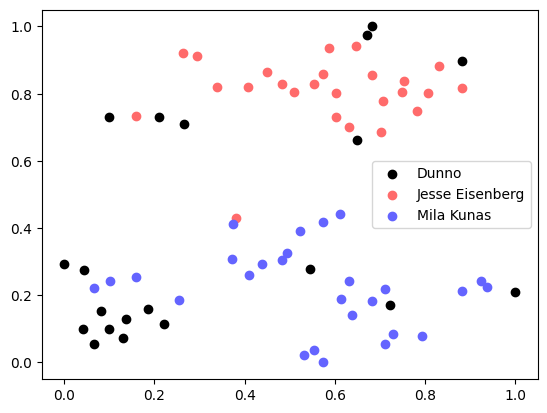

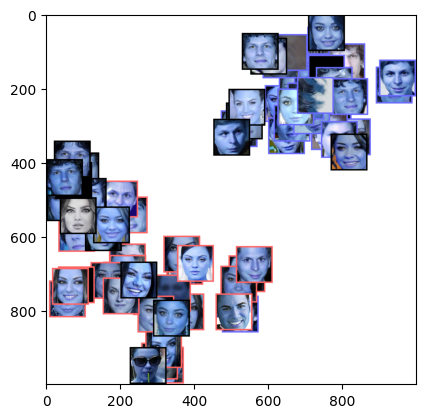

In [175]:
# Colors for the dots in the tSNE graph and for the rectangles around the images
colors_per_class = {
    0: [0, 0, 0],
    1: [255, 107, 107],
    2: [100, 100, 255]
}
# Names for the classes to populate the legend
names_per_class = {
    0: "Dunno",
    1: "Jesse Eisenberg",
    2: "Mila Kunas"
}

#
# Class to visualize features and images the features represent
#
class TsneVisualiser:
    def __init__(self):
        self.tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)

    # normalize the values to show them in a 0-1 plot
    def normalize(self, x):
        # compute the distribution range
        value_range = (np.max(x) - np.min(x))

        # move the distribution so that it starts from zero
        # by extracting the minimal value from all its values
        starts_from_zero = x - np.min(x)

        # make the distribution fit [0; 1] by dividing by its range
        return starts_from_zero / value_range

    # Perform the actual t-SNE feature transformation
    def extract_features_embedded(self, features):
        features_embedded = self.tsne.fit_transform(features)

        # extract x and y coordinates representing the positions of the images on T-SNE plot
        tx = features_embedded[:, 0]
        ty = features_embedded[:, 1]

        tx = self.normalize(tx)
        ty = self.normalize(ty)
        return tx, ty

    def visualise_features(self, features, labels):
        tx, ty = self.extract_features_embedded(features)

        # initialize a matplotlib plot
        fig = plt.figure("Jesse or Mila features")
        ax = fig.add_subplot()

        # for every class, we'll add a scatter plot separately
        for label in colors_per_class:
            # find the samples of the current class in the data
            current_label_indices = [i for i, l in enumerate(labels) if l == label]

            # extract the x and y coordinates of the points of this class only
            current_tx = np.take(tx, current_label_indices)
            current_ty = np.take(ty, current_label_indices)

            # convert the class color to matplotlib format
            color = np.array(colors_per_class[label], dtype=np.float32) / 255

            # add a scatter plot with the corresponding color and label
            ax.scatter(current_tx, current_ty, c=color, label=names_per_class[label])

        # show the legend
        ax.legend()

        # don't block when showing the plot
        #plt.show(block=False)

    # Compute the coordinates of the image on the plot
    def compute_plot_coordinates(self, image, x, y, image_centers_area_size, offset):
        image_height, image_width, _ = image.shape

        # compute the image center coordinates on the plot
        center_x = int(image_centers_area_size * x) + offset

        # in matplotlib, the y axis is directed upward
        # to have the same here, we need to mirror the y coordinate
        center_y = int(image_centers_area_size * (1 - y)) + offset

        # knowing the image center,
        # compute the coordinates of the top left and bottom right corner
        tl_x = center_x - int(image_width / 2)
        tl_y = center_y - int(image_height / 2)

        br_x = tl_x + image_width
        br_y = tl_y + image_height

        return tl_x, tl_y, br_x, br_y

    def scale_image(self, image, max_image_size):
        try:
            image = np.array(image, dtype=np.uint8)
            return cv2.resize(image, None, fx=(max_image_size/image.shape[0]), fy=(max_image_size/image.shape[1]))
        except:
            print(f"scale_image failed for image {image.shape} and max size {max_image_size}")
            return image

    def draw_rectangle_by_class(self, image, label):
        image_height, image_width, _ = image.shape

        # get the color corresponding to image class
        color = colors_per_class[label]
        image_with_rect = cv2.rectangle(image, (0, 0), (image_width - 1, image_height - 1), color, thickness=5)

        return image_with_rect

    def visualise_images(self, images, labels, tx, ty):
        # init the plot as white canvas
        plot_size = 1000 # plot size
        tsne_plot = 255 * np.ones((plot_size, plot_size, 3), np.uint8)
        max_image_size = 100
        # we'll put the image centers in the central area of the plot
        # and use offsets to make sure the images fit the plot
        offset = max_image_size // 2
        image_centers_area_size = plot_size - 2 * offset

        # now we'll put a small copy of every image to its corresponding T-SNE coordinate
        for image, label, x, y in zip(images, labels, tx, ty):
            # image = cv2.imread(image_path)

            # scale the image to put it to the plot
            image = self.scale_image(image, max_image_size)

            # draw a rectangle with a color corresponding to the image class
            image = self.draw_rectangle_by_class(image, label)

            # compute the coordinates of the image on the scaled plot visualization
            tl_x, tl_y, br_x, br_y = self.compute_plot_coordinates(image, x, y, image_centers_area_size, offset)

            # put the image to its t-SNE coordinates using numpy sub-array indices
            tsne_plot[tl_y:br_y, tl_x:br_x, :] = image

        image_rgb = cv2.cvtColor(tsne_plot, cv2.COLOR_BGR2RGB)
        # initialize a matplotlib plot
        fig = plt.figure("Jesse or Mila images")
        ax = fig.add_subplot()

        plt.imshow(image_rgb)
        #plt.axis("off")

tv = TsneVisualiser()
tv.visualise_features(hog_features_list, train_Y_removed)
tx, ty = tv.extract_features_embedded(hog_features_list)
tv.visualise_images(train_X, train_Y_removed, tx, ty)


(80, 4356)

### 1.1.2. Discussion
...

## 1.2. Baseline 2: PCA feature extractor
...

In [181]:
#TODO: changed: threshold -> n_components 
#TODO: changed: implemented inverse_transform

class PCAFeatureExtractor(IdentityFeatureExtractor):
    """TODO: rename class with better name"""

    def __init__(self, X, n_components,kernel):
        self.X = X
        self.n_components = n_components
        self.faceshape = list(X)[0].shape
        self.kernel = kernel

        #flatten the matrix
        facematrix = []
        for face in X:
            facematrix.append(face.flatten())
        facematrix = np.array(facematrix)
        self.facematrix = facematrix

        self.pca = PCA(n_components=self.n_components, svd_solver='full').fit(self.facematrix)

        self.kpca = KernelPCA(n_components = self.n_components, kernel=self.kernel, gamma=1e-5, fit_inverse_transform=True).fit(self.facematrix)

    def transform(self):
        return self.pca.transform(self.facematrix)
    
    def inverse_transform(self, X):
        return self.pca.inverse_transform(X)
    
    def transform_KPCA(self):
        return self.pca.transform(self.facematrix)
    
    def inverse_transform_KPCA(self, X):
        return self.pca.inverse_transform(X)
    
    def GetAllPCAFeatures(self,doPrint = False):
        X_pca = self.transform()
        X_Kpca = self.transform_KPCA()
        if doPrint:
            print("Original dimension:", self.faceshape)
            print("Len explained_variance_ratio_:", len(self.pca.explained_variance_ratio_))
            print("Reduced dimension:", X_pca.shape)
            cum_var = np.cumsum(self.pca.explained_variance_ratio_)
            print("Cumulative explained variance:", cum_var[-1])
        return np.concatenate((X_Kpca,X_pca), axis=1)



Original dimension: (100, 100, 3)
Len explained_variance_ratio_: 20
Reduced dimension: (72, 20)
Cumulative explained variance: 0.8243796302666228


C:\Users\warrd\AppData\Local\Temp\ipykernel_11912\1128977986.py:65: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(current_tx, current_ty, c=color, label=names_per_class[label])


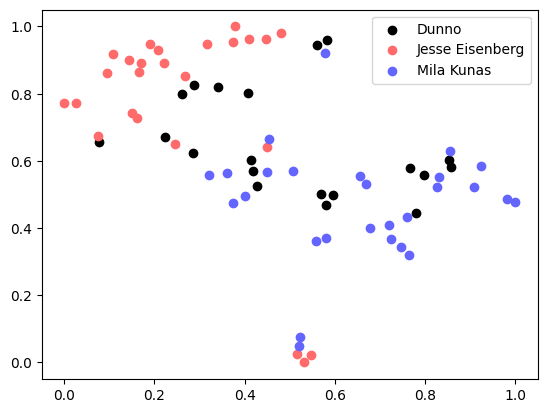

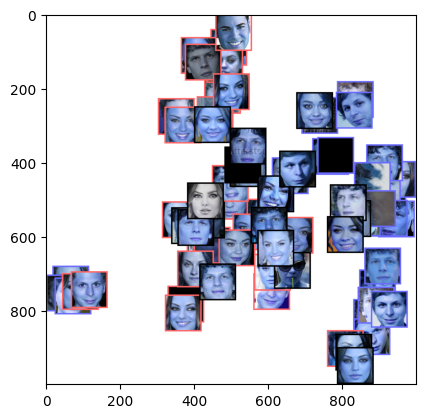

In [ ]:
#features needed for 
n_components = 20
kernel       = 'rbf'
pcaClass     = PCAFeatureExtractor(X=train_X_removed, n_components=n_components, kernel = kernel)
Features     = pcaClass.GetAllPCAFeatures()

### 1.2.1. Eigenface Plots
...

In [ ]:
def plot_eigenfaces(components, reshape_dims):
    """Show the first 16 eigenfaces"""
    _, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(7,9))
    for i in range(16):
        eigenface = minmax_scale(components[i]).reshape(reshape_dims)
        axes[i%4][i//4].imshow(eigenface, cmap="gray")  # TODO: try different rescalers
    plt.show()


plot_eigenfaces(components=pca.components_, reshape_dims=pcaClass.faceshape)

In [ ]:
# TODO: this was for fun, we can delete it
def plot_mean_and_random_faces(pca, pca_class):
    """Visualize the mean face and random face"""
    n_components = len(pca.explained_variance_ratio_)
    eigenfaces = pca.components_[:n_components]
    weights = eigenfaces @ (pca_class.facematrix - pca.mean_).T

    _, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6,4))
    axes[0].imshow(minmax_scale(pca.mean_).reshape(pca_class.faceshape), cmap="gray")  # TODO: try different rescalers
    axes[0].set_title("Mean face")
    random_weights = np.random.randn(n_components) * weights.std()
    newface = random_weights @ eigenfaces + pca.mean_
    axes[1].imshow(minmax_scale(newface).reshape(pca_class.faceshape), cmap="gray")  # TODO: try different rescalers
    axes[1].set_title("Random face")
    plt.show()


plot_mean_and_random_faces(pca=pca, pca_class=pcaClass)

### 1.2.2. Feature Space Plots
...

In [ ]:
# Get all features
ExtractedFeatures = np.concatenate((Features,hog_features_list), axis=1)

tv = TsneVisualiser()
tv.visualise_features(ExtractedFeatures, train_Y_removed)
tx, ty = tv.extract_features_embedded(ExtractedFeatures)
tv.visualise_images(train_X, train_Y_removed, tx, ty)

### 1.2.3. Discussion
...

# 2. Evaluation Metrics
## 2.0. Example: Accuracy
As example metric we take the accuracy. Informally, accuracy is the proportion of correct predictions over the total amount of predictions. It is used a lot in classification but it certainly has its disadvantages...

In [ ]:
from sklearn.metrics import accuracy_score

# 3. Classifiers
## 3.0. Example: The *'not so smart'* classifier
This random classifier is not very complicated. It makes predictions at random, based on the distribution obseved in the training set. **It thus assumes** that the class labels of the test set will be distributed similarly to the training set.

In [ ]:
class RandomClassificationModel:
    """Random classifier, draws a random sample based on class distribution observed 
    during training."""
    
    def fit(self, X, y):
        """Adjusts the class ratio instance variable to the one observed in y. 

        Parameters
        ----------
        X : tensor
            Training set
        y : array
            Training set labels

        Returns
        -------
        self : RandomClassificationModel
        """
        
        self.classes, self.class_ratio = np.unique(y, return_counts=True)
        self.class_ratio = self.class_ratio / self.class_ratio.sum()
        return self
        
    def predict(self, X):
        """Samples labels for the input data. 

        Parameters
        ----------
        X : tensor
            dataset
            
        Returns
        -------
        y_star : array
            'Predicted' labels
        """

        np.random.seed(0)
        return np.random.choice(self.classes, size = X.shape[0], p=self.class_ratio)
    
    def __call__(self, X):
        return self.predict(X)
    

## 3.1. Baseline 1: My favorite classifier
...

In [ ]:
class SVM_Classifier():
    def __init__(self):
        self.hfe = HOGFeatureExtractor()
        self.svc = SVC(kernel='linear', probability=True)  # Linear kernel for good performance
        self.is_trained = False

    def train_with_images(self, train_x_images, train_y):
        hog_features_list = []
        hfe = HOGFeatureExtractor()
        for image in train_x_images:
            result = hfe.transform(image)
            hog_features_list.append(result)
        self.train_with_hog_features(hog_features_list, train_y)

    def train_with_hog_features(self, hog_features_list, train_y):
        self.svc.fit(hog_features_list, train_y)
        self.is_trained = True

    def predict(self, images):
        if self.is_trained:
            hog_features_list = []
            for image in images:
                result = self.hfe.transform(image)
                hog_features_list.append(result)
            y_predict = self.svc.predict(hog_features_list)
            return y_predict
        else: # not trained!!!
            print(f"{self.__class__.__name__}: not trained!")

def plot_image_sequence(data, n, imgs_per_row=7):
    n_rows = 1 + int(n/(imgs_per_row+1))
    n_cols = min(imgs_per_row, n)

    f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))
    for i in range(n):
        if n == 1:
            ax.imshow(data[i])
        elif n_rows > 1:
            ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i])
        else:
            ax[int(i%n)].imshow(data[i])
    plt.show()

svm = SVM_Classifier()
svm.train_with_hog_features(hog_features_list, train_y)

y_predict = svm.predict(test_X)
#    y_predict = svm.predict(test_features_list)
print(len(y_predict))

jesse_eisenberg_predict = []
mila_kunas_predict = []
dunno_predict = []

for i in range(len(y_predict)):
    if y_predict[i] == 1:
        jesse_eisenberg_predict.append(test_X[i])
    elif y_predict[i] == 2:
        mila_kunas_predict.append(test_X[i])
    else:
        dunno_predict.append(test_X[i])

my_favourite_predict = jesse_eisenberg_predict
plot_image_sequence(my_favourite_predict, int(np.min([25, len(my_favourite_predict)])), 5)

# 4. Experiments
<div class="alert alert-block alert-info"> <b>NOTE:</b> Do <i>NOT</i> use this section to keep track of every little change you make in your code! Instead, highlight the most important findings and the major (best) pipelines that you've discovered.  
</div>
<br>

## 4.0. Example: basic pipeline
The basic pipeline takes any input and samples a label based on the class label distribution of the training set. As expected the performance is very poor, predicting approximately 1/4 correctly on the training set. There is a lot of room for improvement but this is left to you ;). 

In [ ]:
feature_extractor = IdentityFeatureExtractor() 
classifier = RandomClassificationModel()

# train the model on the features
classifier.fit(feature_extractor(train_X), train_y)

# model/final pipeline
model = lambda X: classifier(feature_extractor(X))

In [ ]:
# evaluate performance of the model on the training set
train_y_star = model(train_X)

"The performance on the training set is {:.2f}. This however, does not tell us much about the actual performance (generalisability).".format(
    accuracy_score(train_y, train_y_star))

In [ ]:
# predict the labels for the test set 
test_y_star = model(test_X)

# 5. Publishing best results

In [ ]:
submission = test.copy().drop('img', axis = 1)
submission['class'] = test_y_star

submission

In [ ]:
submission.to_csv('submission.csv')

# 6. Discussion
...

In summary we contributed the following: 
* 
